## Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import nltk 
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
import os

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/infres/pmauduit-21/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/infres/pmauduit-21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = torch.device('cuda:0'if torch.cuda.is_available() else "cpu") # Use GPU if available
print('device:', device)
print('current directory:', os.getcwd())

device: cuda:0
current directory: /home/infres/pmauduit-21/project/Good_models


## Data

In [3]:
# Load the data from the gutenberg corpus
alice = gutenberg.raw('carroll-alice.txt')
# Remove the header
header = alice.find("CHAPTER I.")
alice = alice[header:]
# raw_text = alice.lower()
raw_text = alice
# Define char_to_int and int_to_char
chars = sorted(list(set(raw_text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
n_vocab = len(chars)
# Split the data into train, validation, and test sets
train_text = raw_text[:-22067]
val_text = raw_text[-22067:-11681]
test_text = raw_text[-11681:]

print('vocab size:', n_vocab)

vocab size: 69


In [4]:
# summarize the loaded data
n_chars_train = len(train_text)
n_chars_val = len(val_text)
n_chars_test = len(test_text)

print("Total train Characters: ", n_chars_train)
print("Total val Characters: ", n_chars_val)
print("Total test Characters: ", n_chars_test)

# prepare the dataset of input to output pairs encoded as integers
seq_length = 100

dataX_train = []
dataY_train = []
for i in range(0, n_chars_train - seq_length, 1):
    seq_in = train_text[i:i + seq_length]
    seq_out = train_text[i + seq_length]
    dataX_train.append([char_to_int[char] for char in seq_in])
    dataY_train.append(char_to_int[seq_out])
n_patterns_train = len(dataX_train)
print("Total Patterns train: ", n_patterns_train)
# reshape X to be [samples, time steps, features]
X_train = torch.tensor(dataX_train, dtype=torch.long).reshape(n_patterns_train, seq_length, 1)
y_train = torch.tensor(dataY_train, dtype=torch.long)

dataX_test = []
dataY_test = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = test_text[i:i + seq_length]
    seq_out = test_text[i + seq_length]
    dataX_test.append([char_to_int[char] for char in seq_in])
    dataY_test.append(char_to_int[seq_out])
n_patterns_test = len(dataX_test)
print("Total Patterns test: ", n_patterns_test)
X_test = torch.tensor(dataX_test, dtype=torch.long).reshape(n_patterns_test, seq_length, 1)
y_test = torch.tensor(dataY_test, dtype=torch.long)

dataX_val = []
dataY_val = []
for i in range(0, n_chars_val - seq_length, 1):
    seq_in = val_text[i:i + seq_length]
    seq_out = val_text[i + seq_length]
    dataX_val.append([char_to_int[char] for char in seq_in])
    dataY_val.append(char_to_int[seq_out])
n_patterns_val = len(dataX_val)
print("Total Patterns val: ", n_patterns_val)
X_val = torch.tensor(dataX_val, dtype=torch.long).reshape(n_patterns_val, seq_length, 1)
y_val = torch.tensor(dataY_val, dtype=torch.long)


Total train Characters:  122270
Total val Characters:  10386
Total test Characters:  11681
Total Patterns train:  122170
Total Patterns test:  11581
Total Patterns val:  10286


## Model

In [5]:
from tqdm import trange

def train_model(name):
    writer = SummaryWriter(log_dir=f'runs/{name}')
    best_model = None
    best_loss = float('inf')
    iter = 0
    val_cnt = 0
    for epoch in trange(n_epochs):
        model.train()
        for i, (X_batch, y_batch) in enumerate(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            writer.add_scalar('Loss/train', loss.item(), iter)
            iter += 1
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += loss_fn(y_pred, y_batch).item()
        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict() 
            val_cnt = 0
        else:
            val_cnt += 1
        if val_cnt == early_stopping:
            print(f'Early stopping at epoch {epoch}')
            break  
        # print(f'Epoch {epoch}, val_loss: {val_loss}')
    torch.save(best_model, f'{name}.pt')
    writer.close()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss}')

In [109]:
class CharModel(nn.Module):
    def __init__(self, n_vocab, embedding_dim=128, hidden_size=256, num_layers=2, dropout=0.2, norm=False, type = 'lstm'):
        super().__init__()
        if embedding_dim > 1:
            self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim)   

        if type == 'lstm':
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif type == 'gru':
            self.lstm = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        elif type == 'rnn':
            self.lstm = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        if norm:
            self.norm = nn.LayerNorm(hidden_size)
        self.linear = nn.Linear(hidden_size, n_vocab)

    def forward(self, x):
        # Convert input to Long type
        if hasattr(self, 'embedding'):
            x = x.long().squeeze(-1)
            x = self.embedding(x)
        else:
            x = x/float(n_vocab)
            if x.dim() == 2:
                x.unsqueeze_(-1) # Problem ???
        x, _ = self.lstm(x)
        # Take only the last output
        if x.dim() == 2:
            x = x.unsqueeze(0) # Problem with batch size = 1 during inference
        x = x[:, -1, :]
        # Normalize
        if hasattr(self, 'norm'):
            x = self.norm(x)
        x = self.linear(self.dropout(x))
        return x
    

In [7]:
types = ['lstm', 'rnn']
# types = ['rnn']
num_layers = [1, 2]
hidden_size = 256
# embedding_dim = [1,50]
embedding_dim = [1]
norm = False
dropout = 0
early_stopping = 10
n_epochs = 50
batch_size = 512
for t in types:
    for l in num_layers:
        for e in embedding_dim:
            model = CharModel(n_vocab, embedding_dim=e, hidden_size=hidden_size, num_layers=l, dropout=dropout, norm=norm, type=t).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            loss_fn = nn.CrossEntropyLoss()
            loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
            val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
            test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
            train_model(f'default_{t}_layers_{l}')

 62%|██████▏   | 31/50 [01:22<00:50,  2.67s/it]


Early stopping at epoch 31
Test loss: 2.676587612732597


 58%|█████▊    | 29/50 [01:49<01:19,  3.78s/it]


Early stopping at epoch 29
Test loss: 2.3867270220880923


 86%|████████▌ | 43/50 [01:31<00:14,  2.13s/it]


Early stopping at epoch 43
Test loss: 2.6802212362704068


 92%|█████████▏| 46/50 [02:34<00:13,  3.35s/it]

Early stopping at epoch 46


Test loss: 2.2934982154680337


In [85]:
types = ['lstm']
num_layers = [2]
hidden_size = 256
# embedding_dim = [1,50]
embedding_dim = [50]
norm = True
dropout = 0.2
early_stopping = 10
n_epochs = 20
batch_size = 512
for t in types:
    for l in num_layers:
        for e in embedding_dim:
            model = CharModel(n_vocab, embedding_dim=e, hidden_size=hidden_size, num_layers=l, dropout=dropout, norm=norm, type=t).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            loss_fn = nn.CrossEntropyLoss()
            loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
            val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
            test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
            train_model(f'default_{t}_layers_{l}_embedding_{e}')

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:57<00:00,  5.86s/it]

Test loss: 1.801982864089634


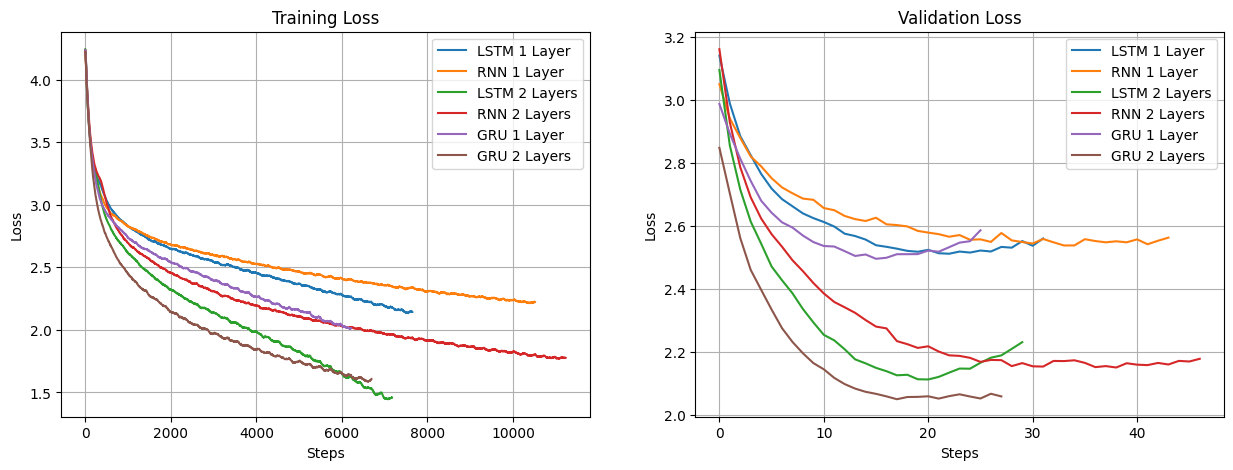

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Define the paths to your log directories
logdirs = [
    ('LSTM 1 Layer', '/home/infres/pmauduit-21/project/Good_models/runs/default_lstm_layers_1'),
    ('RNN 1 Layer', '/home/infres/pmauduit-21/project/Good_models/runs/default_rnn_layers_1'),
    ('LSTM 2 Layers', '/home/infres/pmauduit-21/project/Good_models/runs/default_lstm_layers_2'),
    ('RNN 2 Layers', '/home/infres/pmauduit-21/project/Good_models/runs/default_rnn_layers_2'),
    ('GRU 1 Layer', '/home/infres/pmauduit-21/project/Good_models/runs/default_gru_layers_1'),
    ('GRU 2 Layers', '/home/infres/pmauduit-21/project/Good_models/runs/default_gru_layers_2')
]

# Smoothing function
def smooth(values, factor=0.99):
    smoothed_values = []
    for v in values:
        if smoothed_values:
            smoothed_values.append(smoothed_values[-1] * factor + v * (1 - factor))
        else:
            smoothed_values.append(v)
    return smoothed_values

# Extract scalars from TensorBoard logs
def extract_scalars(logdir, tag):
    ea = event_accumulator.EventAccumulator(logdir)
    ea.Reload()
    steps = []
    values = []
    for event in ea.Scalars(tag):
        steps.append(event.step)
        values.append(event.value)
    return steps, values

f = plt.figure(figsize=(15, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)

for name, logdir in logdirs:
    train_tag = 'Loss/train'    
    train_steps, train_values = extract_scalars(logdir, train_tag)    
    train_values_smoothed = smooth(train_values)    
    plt.plot(train_steps, train_values_smoothed, label=f'{name}')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

for name, logdir in logdirs:
    val_tag = 'Loss/val'    
    val_steps, val_values = extract_scalars(logdir, val_tag)    
    val_values_smoothed = smooth(val_values, factor=0.2)    
    plt.plot(val_steps, val_values_smoothed, label=f'{name}')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# types = ['lstm', 'gru', 'rnn']
types = ['lstm', 'rnn']
# num_layers = [1, 2, 3] 
num_layers = [1, 2]
# hidden_size = [128, 256, 512]
hidden_size = [128, 256]
# embedding_dim = [1, 50, 100]
embedding_dim = [50]
# dropout = [0, 0.2, 0.5]
dropout = [0, 0.2]
# norm = [False, True]
norm = [False]
early_stopping = 5
n_epochs = 20
batch_size = 1024

for t in types:
    for l in num_layers:
        for h in hidden_size:
            for e in embedding_dim:
                for n in norm:
                    if l > 1:
                        dropout = [0, 0.2]
                    else:
                        dropout = [0]
                    for d in dropout:                    
                        name = f'{t}_layers_{l}_hid_{h}_emb_{e}_drop_{d}_norm_{n}'
                        print(name)
                        model = CharModel(n_vocab=n_vocab, embedding_dim=e, hidden_size=h, num_layers=l, dropout=d, norm=n, type = t)
                        model.to(device)
                        optimizer = optim.Adam(model.parameters())
                        loss_fn = nn.CrossEntropyLoss()
                        loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
                        val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), shuffle=False, batch_size=batch_size)
                        test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)
                        train_model(name)
                        print('')

## Loading model

In [120]:
# Generation using the trained model
# model = CharModel(n_vocab, embedding_dim=1, hidden_size=256, num_layers=2, dropout=0, norm=False, type='gru').to(device)
# best_model = torch.load("default_gru_layers_2.pt")

# model = CharModel(n_vocab, embedding_dim=1, hidden_size=256, num_layers=2, dropout=0, norm=False, type='lstm').to(device)
# best_model = torch.load("default_lstm_layers_2.pt")

model = CharModel(n_vocab, embedding_dim=50, hidden_size=256, num_layers=2, dropout=0.2, norm=True, type='lstm').to(device)
best_model = torch.load("default_lstm_layers_2_embedding_50.pt")

# best_model = torch.load(f'{name}.pt')

n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)

<All keys matched successfully>

## Generating text

In [121]:
def apply_temperature_scaling(logits, temperature):
    # Scale logits by the temperature
    logits = logits / temperature
    # Convert scaled logits to probabilities
    probs = torch.softmax(logits, dim=-1)
    return probs

# Nucleus sampling function
def nucleus_sampling(probs, p, device):
    # Sort the probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)    
    # Find the cutoff index
    cutoff_index = torch.searchsorted(cumulative_probs, torch.tensor(p, device=device)).item() + 1
    # Select the top probabilities
    top_probs = sorted_probs[:cutoff_index]
    top_indices = sorted_indices[:cutoff_index]    
    # Normalize the selected top probabilities
    top_probs = top_probs / torch.sum(top_probs)    
    # Sample from the selected top probabilities
    sampled_index = torch.multinomial(top_probs, 1).item()    
    return top_indices[sampled_index].item()

In [127]:
def generate_from_text(temperature=None, p = None, prompt=None):
    if prompt is None:
        start = np.random.randint(0, len(raw_text)-seq_length)
        text_prompt = raw_text[start:start+seq_length]
        pattern = [char_to_int[c] for c in text_prompt]
        print('Prompt: "%s"' % text_prompt)
    else:
        pattern = [char_to_int[c] for c in prompt]
        print('Prompt: "%s"' % prompt)
    model.eval()
    print('-'*100)
    generated_text = ""
    if prompt is not None:
        print(prompt, end="")
    with torch.no_grad():
        for i in range(1000):
            x = np.reshape(pattern, (1, len(pattern)))
            # x = torch.tensor(x, dtype=torch.float32)
            x = torch.tensor(x, dtype=torch.long)
            logits = model(x.to(device))
            if temperature is not None:
                scaled_probs = apply_temperature_scaling(logits, temperature)
                if p is not None:                
                    scaled_probs = scaled_probs.squeeze()
                    index = nucleus_sampling(scaled_probs, p, device)
                else:
                    index = torch.multinomial(scaled_probs, 1).item()
            else:
                index = int(logits.argmax())
            result = int_to_char[index]
            generated_text += result
            print(result, end="")
            pattern.append(index)
            if len(pattern) > seq_length:
                pattern = pattern[1:]
    print()
    print("Done.")
    return generated_text

print("Temperature scaling, with random prompt")
print('-' * 100)
generated_text = generate_from_text(temperature=0.9,p = 0.9 , prompt='A')
# generated_text = generate_from_text(temperature=0.9 , prompt='A')
# generated_text = generate_from_text(temperature=0.9)
# generated_text = generate_from_text()



Temperature scaling, with random prompt
----------------------------------------------------------------------------------------------------
Prompt: "A"
----------------------------------------------------------------------------------------------------
Alice could think of a sears of conversation. While she
was speaking to first, and went on, 'End what to sigh to be a grin,
     And up a draw in the conversation of CHATTHIG.' The Queen turned round her head.

'The others was to a minute or two, and mading at Alice to the staid of the game,' said the Caterpillar.

'Well, I've tried the same size to have been will be
off much frightened to my serpent, and manage at the world be seen as the right size to work with the world what I should like to see a beginning,' Alice couting that it was very like the creatures of his
heldies.

'What I eat was you find heree you delistanted its
arms feeling at the other question, she went back to the garden, and her head mournfully. 'It's beautiful Soup

## Text Generation

In [545]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_score(generated_text, reference_text):
    reference = [reference_text.split()]
    candidate = generated_text.split()

    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return bleu_score

In [546]:
reference_text = raw_text[-1000:]  # Using the last 1000 characters of raw_text as the reference

bleu_score = calculate_bleu_score(generated_text, reference_text)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.011734159839341842


In [571]:
def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

ttr = calculate_ttr(generated_text)
print(f"TTR: {ttr}")

TTR: 0.6432160804020101


In [610]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def calculate_perplexity(text, model, tokenizer, device):
    encodings = tokenizer(text, return_tensors='pt')
    max_length = model.config.n_positions
    stride = 512

    lls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone().to(device)
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs.loss * trg_len

        lls.append(log_likelihood)

    ppl = torch.exp(torch.stack(lls).sum() / end_loc)
    return ppl.item()

# Reference text for BLEU score calculation
reference_text = raw_text[-1000:]


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
perplexity = calculate_perplexity(generated_text, gpt2_model, tokenizer, device)
print(f"Perplexity: {perplexity}")

perplexity = calculate_perplexity(reference_text, gpt2_model, tokenizer, device)
print(f"Perplexity: {perplexity}")


Perplexity: 183.6708526611328
Perplexity: 50.75355911254883


: 